In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import pandas as pd
import numpy as np

# Runtime plots

In [2]:
def get_run_data(res_dir):
    files = os.listdir(res_dir)
    res = {}
    for f in files:
        data = json.load(open(os.path.join(res_dir, f), 'r'))
        start = data['time_script_start']
        end = data['time_script_complete']
        res[int(f.split('_')[1])] = (end-start) /60
        
    res = pd.Series(res).sort_index()
    res.name = res_dir
    return res

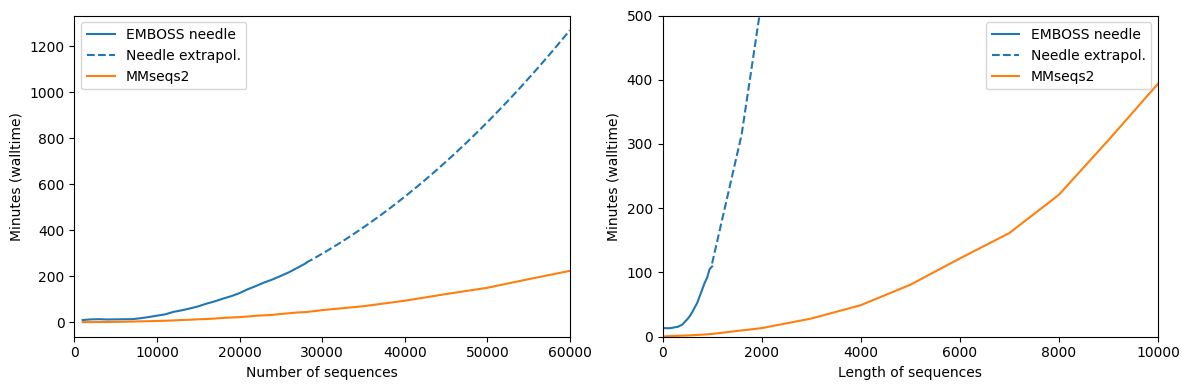

In [ ]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
performance_needle = get_run_data('runtime_benchmark/needle_size_run1/')
performance_mmseqs2 = get_run_data('runtime_benchmark/mmseqs2_size_run1/')

poly = np.polynomial.Polynomial.fit(x = performance_needle.index, y=performance_needle, deg=2)
x, y = poly.linspace(100, [performance_needle.index.max(), 60000])

performance_needle.plot(label='EMBOSS needle')
prev_color = plt.gca().lines[-1].get_color()
pd.Series(y, index=x).plot(label='Needle extrapol.', linestyle='--', color = prev_color)
plt.xlabel('Number of sequences')
plt.ylabel('Minutes (walltime)')
performance_mmseqs2.plot(label='MMseqs2')
plt.legend()

#plt.xlim(0, 10000)
plt.xlim(0, 60000)

plt.subplot(1,2,2)

performance_needle = get_run_data('runtime_benchmark/needle_length_run1/')
performance_mmseqs2 = get_run_data('runtime_benchmark/mmseqs2_length_run1/')

poly = np.polynomial.Polynomial.fit(x = performance_needle.index, y=performance_needle, deg=2)
x, y = poly.linspace(100, [performance_needle.index.max(), 60000])

performance_needle.plot(label='EMBOSS needle')
prev_color = plt.gca().lines[-1].get_color()
pd.Series(y, index=x).plot(label='Needle extrapol.', linestyle='--', color = prev_color)

plt.xlabel('Length of sequences')
plt.ylabel('Minutes (walltime)')
performance_mmseqs2.plot(label='MMseqs2')
plt.legend()

plt.xlim(0, 10000)
plt.ylim(0, 500)

plt.tight_layout()
#plt.suptitle('Time complexity of Graph-Part')

# Partition quality plots

In [2]:
def add_counts_to_seaborn_plot(ax, df, separator='\n', total=None):
    '''Add the observation counts to a seaborn violin plot/box plot'''
    dataframe_key = ax.get_ylabel()
    df[dataframe_key] = df[dataframe_key].astype(str)
    counts = df[dataframe_key].value_counts()
    new_ticks = []
    for label in ax.get_yticklabels():
        label_text = label.get_text()
        n = counts.loc[label_text]
        if total is None:
            new_ticks.append(label_text + separator + '('+str(n)+')')
        else:
            # new_ticks.append(label_text + separator + '('+str(n)+', {:.2f}%)'.format(n/total*100))
            new_ticks.append(label_text + separator + '({:.2f}%)'.format(n/total*100))
        
    ax.set_yticklabels(new_ticks)

## Protein

In [8]:
def get_data_as_df(prefix, base_path='results/'):
    '''Get partitioning data as df for easy plotting.
    One row per sequence.
    variable	value	algorithm
    '''
    plot_dict = {'MMseqs2 Partitioning': f'{base_path}/{prefix}_partition_mmseqs2_cmode0_qc.csv',
             'MMseqs2 Reduction': f'{base_path}/{prefix}_reduction_mmseqs2_cmode0_qc.csv',
             'CD-HIT Partitioning': f'{base_path}/{prefix}_partition_cd_hit_qc.csv',
             'CD-HIT Reduction': f'{base_path}/{prefix}_reduction_cd_hit_qc.csv',
             'Hobohm 2 MMseqs2': f'{base_path}/{prefix}_reduction_hobohm2_mmseqs2_qc.csv',
             'Hobohm 2 needle': f'{base_path}/{prefix}_reduction_hobohm2_qc.csv',
             'Graph-Part MMseqs2': f'{base_path}/{prefix}_partition_graphpart_mmseqs2_qc.csv',
             'Graph-Part needle': f'{base_path}/{prefix}_partition_graphpart_needle_qc.csv',
             
    }
    
    dfs = []
    for name, file in plot_dict.items():

        df = pd.read_csv(file)
        df_m = pd.melt(df, value_vars=['max_ident_other'])
        df_m['algorithm'] = name
        dfs.append(df_m)

    df = pd.concat(dfs)
    df['value'] = df['value']*100
    
    return df

In [4]:
PROPS = {
    #'boxprops':{'facecolor':'none', 'edgecolor':'black'},
    'medianprops':{'color':'black'},
    'whiskerprops':{'color':'black'},
    'capprops':{'color':'black'},
    'fliersize':0.5,
    'width':0.7,
}

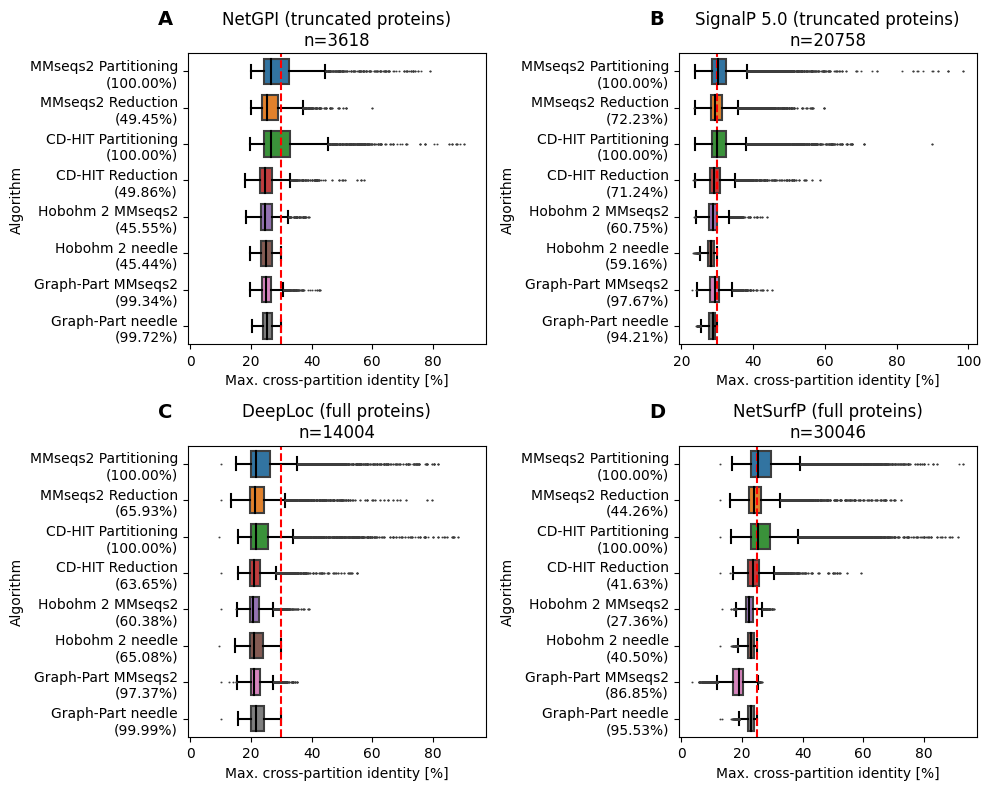

In [11]:
fig = plt.figure(figsize=(10,8))

with sns.axes_style(None):
    plt.subplot(2,2,1)
    df = get_data_as_df('netgpi')
    ax1 = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
    total = df.loc[df['algorithm'] == 'CD-HIT Partitioning'].shape[0]
    add_counts_to_seaborn_plot(ax1, df, total=total)
    plt.axvline(30, linestyle='--', color='red')
    plt.title(f'NetGPI (truncated proteins)\nn={total}')
    plt.xlabel('Max. cross-partition identity [%]')
    plt.ylabel('Algorithm')

    ax1.text(-0.1, 1.1, 'A', transform=ax1.transAxes, 
            size=14, weight='bold')

    plt.subplot(2,2,2)
    df = get_data_as_df('signalp')
    ax = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
    total = df.loc[df['algorithm'] == 'CD-HIT Partitioning'].shape[0]
    add_counts_to_seaborn_plot(ax, df, total=total)
    plt.axvline(30, linestyle='--', color='red')
    plt.title(f'SignalP 5.0 (truncated proteins)\nn={total}')
    plt.xlabel('Max. cross-partition identity [%]')
    plt.ylabel('Algorithm')
    
    ax.text(-0.1, 1.1, 'B', transform=ax.transAxes, 
            size=14, weight='bold')

    plt.subplot(2,2,3, sharex=ax1)
    df = get_data_as_df('deeploc')
    ax = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
    total = df.loc[df['algorithm'] == 'CD-HIT Partitioning'].shape[0]
    add_counts_to_seaborn_plot(ax, df, total=total)
    plt.axvline(30, linestyle='--', color='red')
    plt.title(f'DeepLoc (full proteins)\nn={total}')
    plt.xlabel('Max. cross-partition identity [%]')
    plt.ylabel('Algorithm')
    
    ax.text(-0.1, 1.1, 'C', transform=ax.transAxes, 
            size=14, weight='bold')
    

    plt.subplot(2,2,4, sharex=ax1)
    df = get_data_as_df('netsurfp')
    ax = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
    total = df.loc[df['algorithm'] == 'CD-HIT Partitioning'].shape[0]
    add_counts_to_seaborn_plot(ax, df, total=total)
    plt.axvline(25, linestyle='--', color='red')
    plt.title(f'NetSurfP (full proteins)\nn={total}')
    plt.xlabel('Max. cross-partition identity [%]')
    plt.ylabel('Algorithm')
    
    ax.text(-0.1, 1.1, 'D', transform=ax.transAxes, 
            size=14, weight='bold')
    
    plt.tight_layout()
    plt.savefig('figure_2.png', dpi=1200)
    plt.savefig('figure_2.svg')

In [9]:
threshold = 0.3
overlap = {}
df = get_data_as_df('netgpi')
overlap['netgpi'] = df.groupby('algorithm').apply(lambda x: (x['value']>threshold).sum()/x.shape[0])
df = get_data_as_df('signalp')
overlap['signalp'] = df.groupby('algorithm').apply(lambda x: (x['value']>threshold).sum()/x.shape[0])
df = get_data_as_df('deeploc')
overlap['deeploc'] = df.groupby('algorithm').apply(lambda x: (x['value']>threshold).sum()/x.shape[0])

pd.DataFrame.from_dict(overlap).style.format('{:.2%}')

,netgpi,signalp,deeploc
algorithm,,,
CD-HIT Partitioning,32.09%,48.83%,12.23%
CD-HIT Reduction,13.97%,33.64%,4.97%
Graph-Part MMseqs2,5.84%,33.25%,0.92%
Graph-Part needle,0.00%,0.00%,0.00%
Hobohm 2 MMseqs2,9.95%,23.38%,1.81%
Hobohm 2 needle,0.00%,0.00%,0.00%
MMseqs2 Partitioning,31.84%,50.97%,14.54%
MMseqs2 Reduction,21.63%,39.72%,9.24%


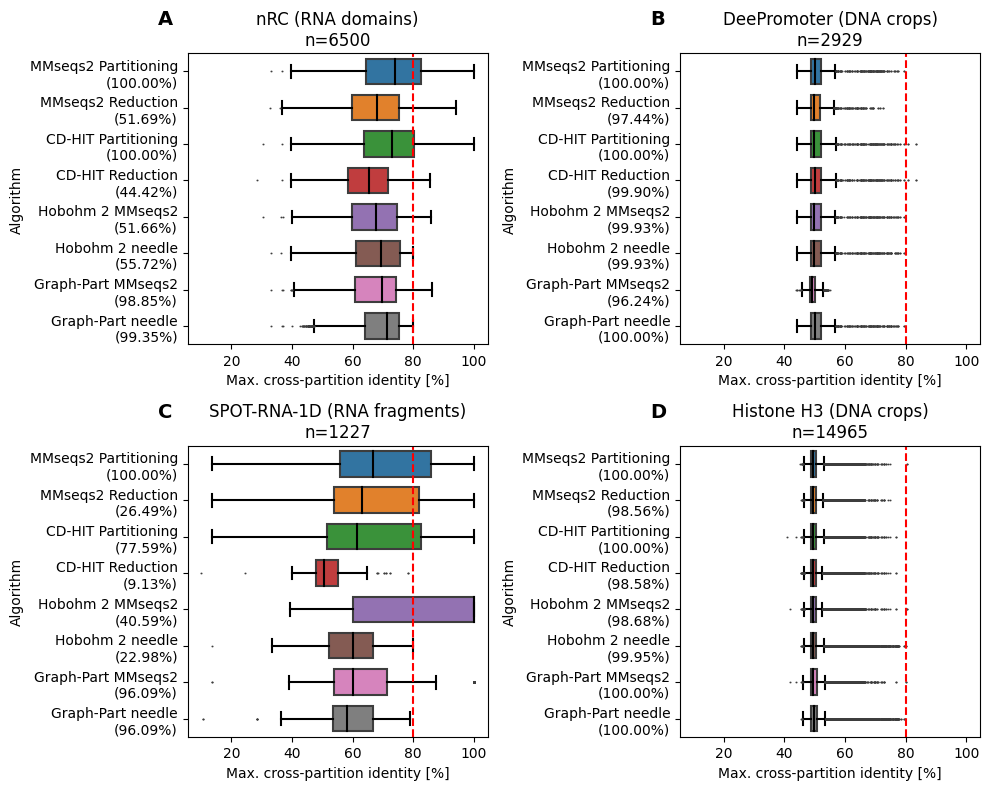

In [12]:
plt.figure(figsize=(10,8))

with sns.axes_style(None):
    plt.subplot(2,2,1)
    df = get_data_as_df('nrc')
    ax = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
    total = df.loc[df['algorithm'] == 'CD-HIT Partitioning'].shape[0]
    add_counts_to_seaborn_plot(ax, df, total=total)
    plt.axvline(80, linestyle='--', color='red')
    plt.title(f'nRC (RNA domains)\nn={total}')
    plt.xlabel('Max. cross-partition identity [%]')
    plt.ylabel('Algorithm')
    ax.text(-0.1, 1.1, 'A', transform=ax.transAxes, 
            size=14, weight='bold')

    plt.subplot(2,2,2, sharex=ax)
    df = get_data_as_df('deepromoter')
    ax = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
    total = df.loc[df['algorithm'] == 'CD-HIT Partitioning'].shape[0]
    add_counts_to_seaborn_plot(ax, df, total=total)
    plt.axvline(80, linestyle='--', color='red')
    plt.title(f'DeePromoter (DNA crops)\nn={total}')
    plt.xlabel('Max. cross-partition identity [%]')
    plt.ylabel('Algorithm')
    ax.text(-0.1, 1.1, 'B', transform=ax.transAxes, 
            size=14, weight='bold')

    plt.subplot(2,2,3, sharex=ax)
    df = get_data_as_df('spotrna1d')
    ax = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
    total = 1227 #df.loc[df['algorithm'] == 'CD-HIT Partitioning'].shape[0]
    add_counts_to_seaborn_plot(ax, df, total=total)
    plt.axvline(80, linestyle='--', color='red')
    plt.title(f'SPOT-RNA-1D (RNA fragments)\nn={total}')
    plt.xlabel('Max. cross-partition identity [%]')
    plt.ylabel('Algorithm')
    ax.text(-0.1, 1.1, 'C', transform=ax.transAxes, 
            size=14, weight='bold')
    
    plt.subplot(2,2,4, sharex=ax)
    df = get_data_as_df('histone')
    ax = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
    total = df.loc[df['algorithm'] == 'CD-HIT Partitioning'].shape[0]
    add_counts_to_seaborn_plot(ax, df, total=total)
    plt.axvline(80, linestyle='--', color='red')
    plt.title(f'Histone H3 (DNA crops)\nn={total}')
    plt.xlabel('Max. cross-partition identity [%]')
    plt.ylabel('Algorithm')
    ax.text(-0.1, 1.1, 'D', transform=ax.transAxes, 
            size=14, weight='bold')

    plt.tight_layout()
    plt.savefig('figure_3.png', dpi=1200)
    plt.savefig('figure_3.svg')

## Partition balancing plots

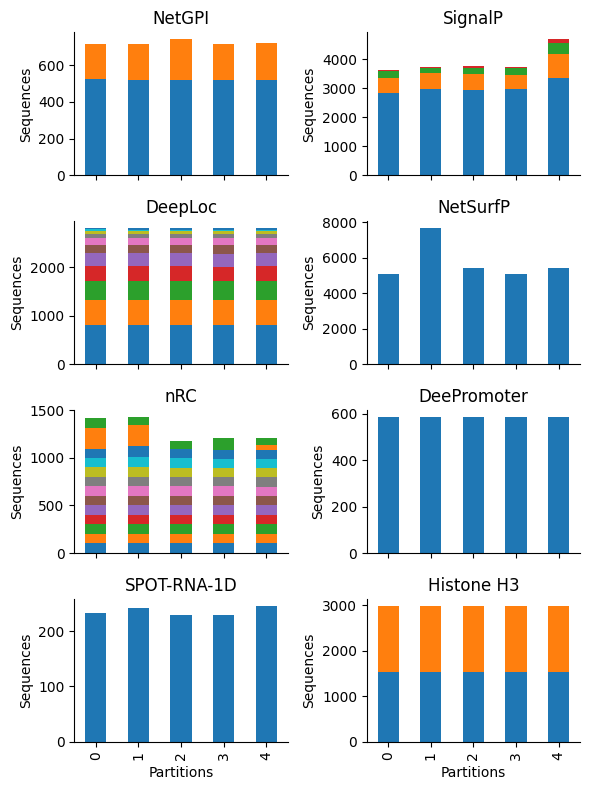

In [28]:
fig, axes = plt.subplots(4,2, figsize=(6,8), sharex=True, sharey=False)

names = ['NetGPI', 'SignalP', 'DeepLoc', 'NetSurfP', 'nRC', 'DeePromoter', 'SPOT-RNA-1D', 'Histone H3']
for i, dataset in enumerate(['netgpi', 'signalp', 'deeploc', 'netsurfp', 'nrc', 'deepromoter', 'spotrna1d', 'histone']):

    df = pd.read_csv(f'results/{dataset}_partition_graphpart_needle_qc.csv')
    # make counts per partition per label
    df = df.groupby(['label-val', 'cluster']).count().reset_index()
    df = df.pivot(index='label-val', columns='cluster', values='AC')
    df = df.fillna(0)
    df = df.astype(int)
    df = df.rename(columns={0:'0', 1:'1', 2:'2', 3:'3', 4:'4'})

    # stacked barplot for each partition, no legend
    # labels sorted by count
    df = df.reindex(df.sum(axis=1).sort_values(ascending=False).index)
    df.T.plot.bar(stacked=True, ax=axes.flatten()[i])
    axes.flatten()[i].get_legend().remove()

    # annotate with counts
    # for j, col in enumerate(df.columns):
    #     for k, val in enumerate(df[col]):
    #         # note that the barplot is stacked.
    #         # below won't work for stacked barplots.
    #         # axes.flatten()[i].text(j, val/2, str(val), ha='center', va='center')
    #         axes.flatten()[i].text(j, val, str(val), ha='center', va='bottom')


    axes.flatten()[i].set_title(dataset)
    axes.flatten()[i].set_ylabel('Sequences')
    axes.flatten()[i].set_xlabel('Partitions')
    axes.flatten()[i].set_title(names[i])
    sns.despine()

plt.tight_layout()

plt.savefig('label_balancing.png', dpi=1200)
plt.savefig('label_balancing.svg')


In [3]:
dataset= 'nrc'
df = pd.read_csv(f'results/{dataset}_partition_graphpart_needle_qc.csv')
# df = pd.read_csv('results/nrc_reduction_mmseqs2_cmode0_qc.csv')
# make counts per partition per label
df = df.groupby(['label-val', 'cluster']).count().reset_index()
df = df.pivot(index='label-val', columns='cluster', values='AC')
df = df.fillna(0)
df = df.astype(int)
df = df.rename(columns={0:'0', 1:'1', 2:'2', 3:'3', 4:'4'})

# stacked barplot for each partition, no legend
# labels sorted by count
df = df.reindex(df.sum(axis=1).sort_values(ascending=False).index)
df#.div(df.sum(axis=0)).round(2)*100

cluster,0,1,2,3,4
label-val,,,,,
2,100,100,100,100,100
3,100,100,100,100,100
4,100,100,100,100,100
5,100,100,100,100,100
9,100,100,100,100,100
7,100,100,100,100,99
11,100,100,100,100,99
6,100,100,99,99,99
8,100,106,98,94,99


In [314]:
hobohm_dict = {}
graphpart_dict = {}
for fname in os.listdir('hobohm_benchmark/'):
    num_lines = sum(1 for line in open(os.path.join('hobohm_benchmark',fname)))
    if fname.startswith('graphpart'):
        graphpart_dict[int(fname.split('_')[1].rstrip('.csv'))] = num_lines
    elif fname.startswith('hobohm'):
        hobohm_dict[int(fname.split('_')[1].rstrip('.txt'))] = num_lines

In [315]:
df = pd.DataFrame.from_dict([hobohm_dict, graphpart_dict]).T
df.columns=['Hobohm', 'Graph-Part']
df = df.sort_index()

In [316]:
df

,Hobohm,Graph-Part
10,26.0,NaN
15,70.0,NaN
18,202.0,700.0
19,290.0,809.0
20,426.0,981.0
21,590.0,1249.0
22,821.0,1691.0
23,1020.0,2160.0
24,1195.0,2953.0
25,1341.0,3235.0


Text(0.5, 0, 'Percent identity threshold')

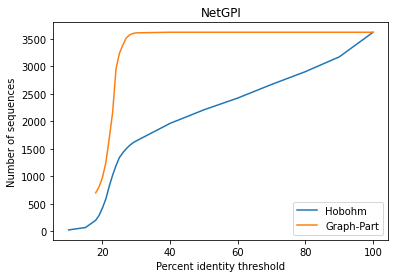

In [318]:
df.plot(title='NetGPI')
plt.ylabel('Number of sequences')
plt.xlabel('Percent identity threshold')
# plt.axvline(20, linestyle='--', color='orange')

## Random baseline

In [4]:
def get_data_as_df(base_path='results/'):
    '''Get partitioning data as df for easy plotting.
    One row per sequence.
    variable	value	algorithm
    '''
    plot_dict = {'NetGPI': f'{base_path}/netgpi_sklearn_qc.csv',
                'SignalP': f'{base_path}/signalp_sklearn_qc.csv',
                'DeepLoc': f'{base_path}/deeploc_sklearn_qc.csv',
                'NetSurfP': f'{base_path}/netsurfp_sklearn_qc.csv',
                'nRC': f'{base_path}/nrc_sklearn_qc.csv',
                'DeePromoter': f'{base_path}/deepromoter_sklearn_qc.csv',
                'SPOT-RNA-1D': f'{base_path}/spotrna1d_sklearn_qc.csv',
                'Histone H3': f'{base_path}/histone_sklearn_qc.csv',


    }
    
    dfs = []
    for name, file in plot_dict.items():

        df = pd.read_csv(file)
        df_m = pd.melt(df, value_vars=['max_ident_other'])
        df_m['Dataset'] = name
        dfs.append(df_m)

    df = pd.concat(dfs)
    
    return df

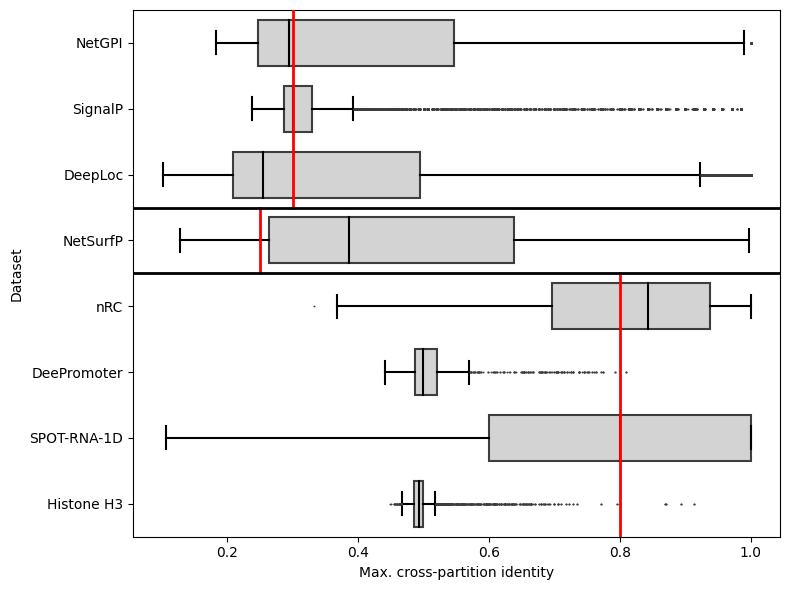

In [10]:
df = get_data_as_df()
df = df.rename(columns={'value':'Max. cross-partition identity'})

# we want to make one boxplot per dataset
# the algorithms with the same threshold should be grouped and have a vertical line 
# indicating the threshold

# a horizontal line should separate the groups

# netgpi and signalp have 0.3 as threshold
# netsurfp has 0.25
# nrc, deeppromoter and spotrna1d have 0.8

plt.figure(figsize=(8,6))

order = ['NetGPI', 'SignalP', 'DeepLoc', 'NetSurfP', 'nRC', 'DeePromoter', 'SPOT-RNA-1D', 'Histone H3']
ax = sns.boxplot(data=df, y='Dataset', x='Max. cross-partition identity', order=order, boxprops={'facecolor':'lightgrey'} , **PROPS)




# add vertical lines for thresholds
# these should not cross the horizontal lines, i.e. the 0.3 line goes until 1.5 only and the 0.8 line goes from 2.5 to 3.5

#ax.axvline(0.3, linestyle='--', color='red') <-- this won't work because it crosses
ax.plot([0.3, 0.3], [-0.5, 2.5], linestyle='-', color='red', zorder=100, linewidth=2)
ax.plot([0.25, 0.25], [2.5, 3.5], linestyle='-', color='red', zorder=100, linewidth=2)
ax.plot([0.8, 0.8], [3.5, 7.5], linestyle='-', color='red', zorder=100, linewidth=2)

# add horizontal lines between groups
ax.axhline(2.5, linestyle='-', color='black', zorder=300, linewidth=2)
ax.axhline(3.5, linestyle='-', color='black', zorder=300, linewidth=2)

plt.tight_layout()
plt.savefig('random_baseline.png', dpi=1200)
plt.savefig('random_baseline.svg')


In [21]:
df

,variable,Max. cross-partition identity,Datataset
0,max_ident_other,0.568,NetGPI
1,max_ident_other,0.314,NetGPI
2,max_ident_other,0.228,NetGPI
3,max_ident_other,0.252,NetGPI
4,max_ident_other,0.271,NetGPI
...,...,...,...
1222,max_ident_other,0.486,SPOT-RNA-1D
1223,max_ident_other,0.486,SPOT-RNA-1D
1224,max_ident_other,0.486,SPOT-RNA-1D
1225,max_ident_other,0.486,SPOT-RNA-1D


In [2]:
df = pd.read_csv('results/netgpi_sklearn_qc.csv')

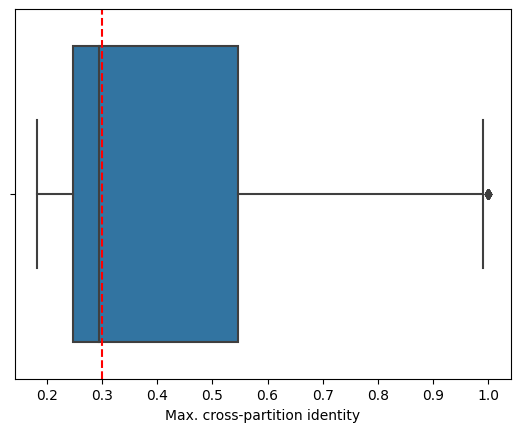

In [7]:
sns.boxplot(x= df['max_ident_other'])
plt.xlabel('Max. cross-partition identity')
plt.axvline(0.3, linestyle='--', color='red')

## Train-Val-Test split

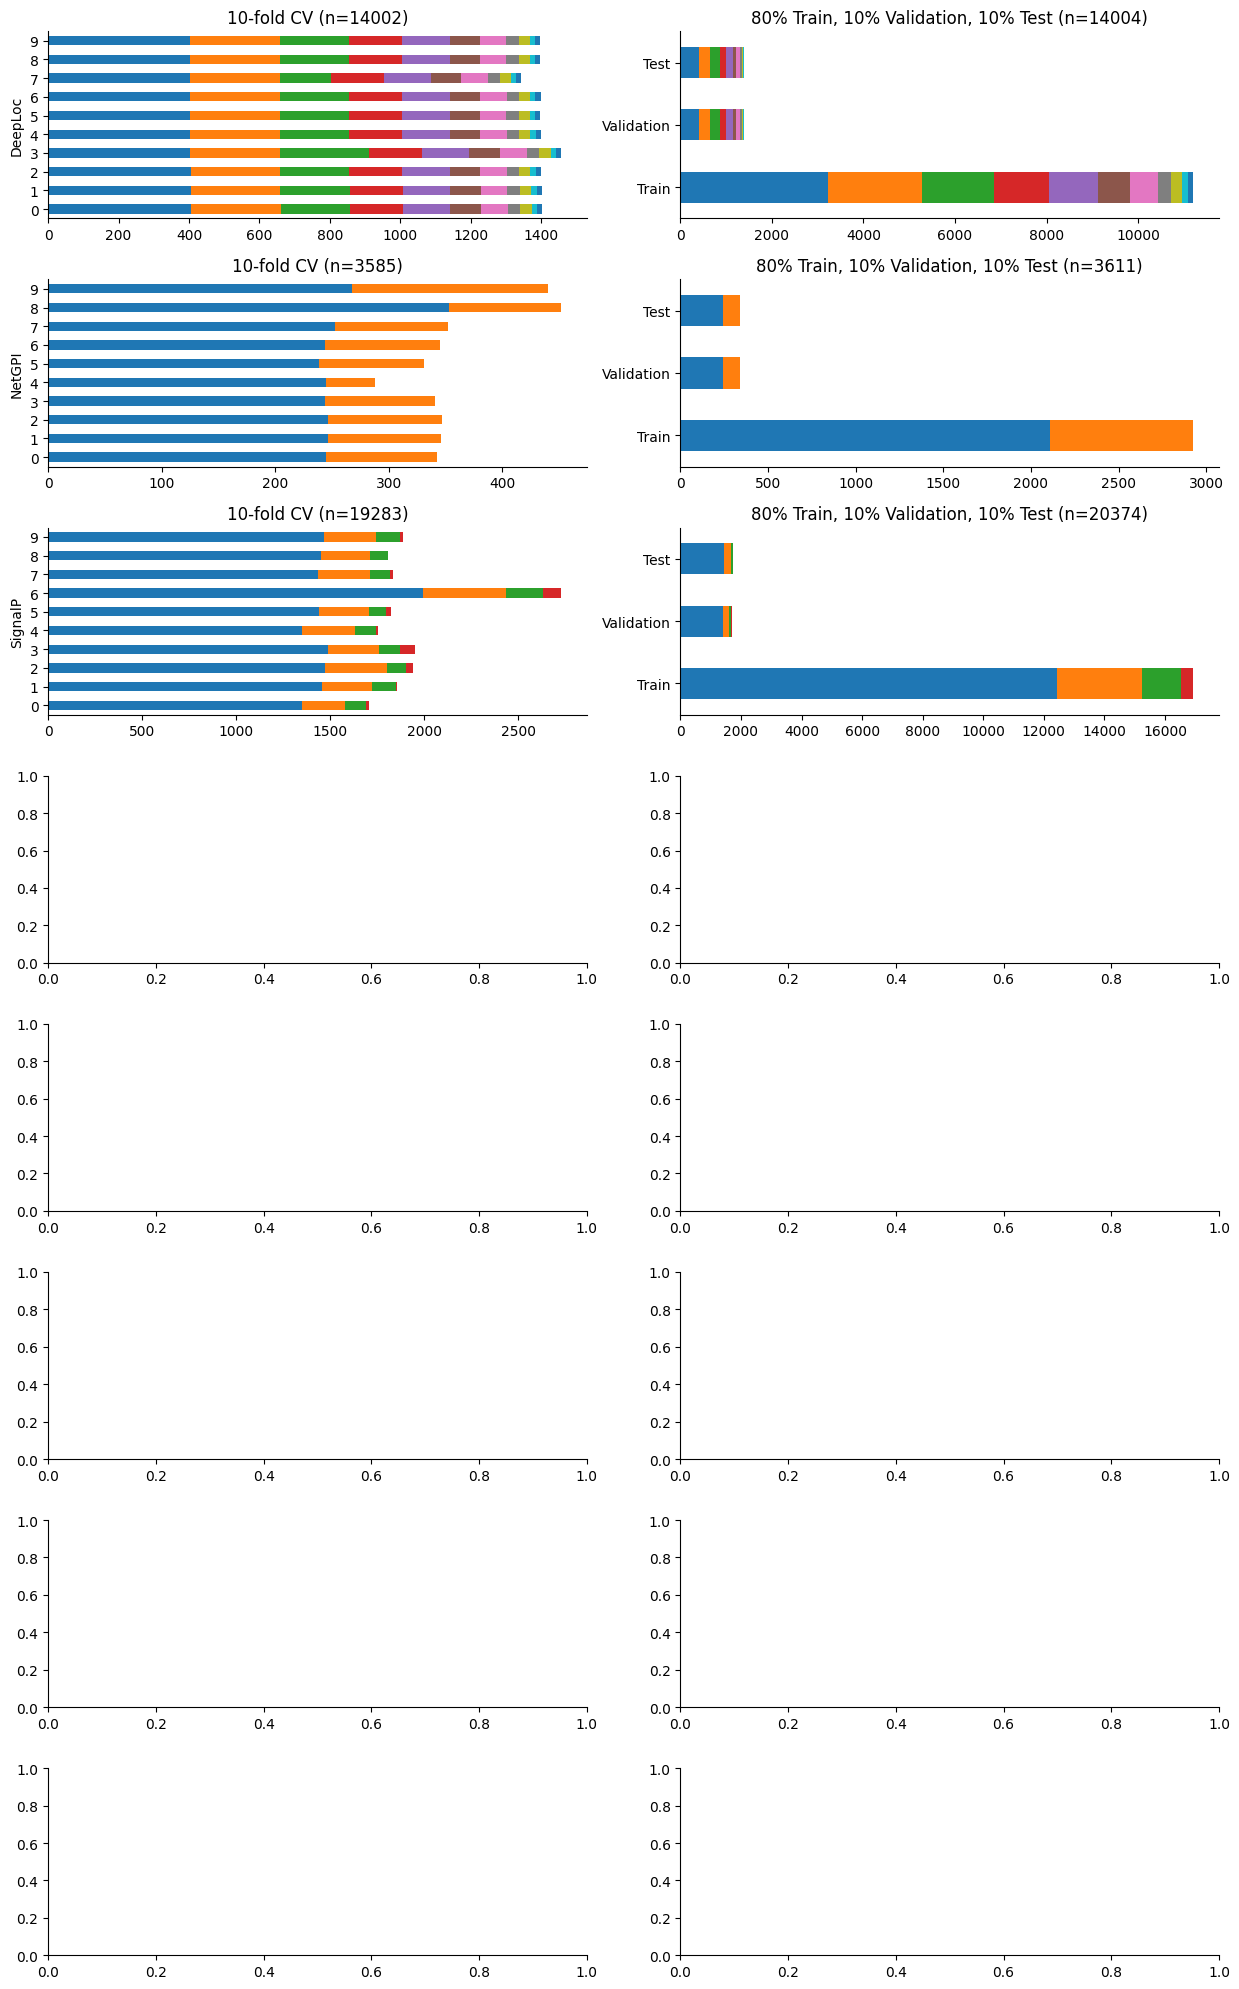

In [5]:
# make counts per partition per label
def plot_dataset(name, axes, idx, title=None):
    df = pd.read_csv(f'results_splitmode/{name}_10fold.csv')
    df = df.groupby(['label-val', 'cluster']).count().reset_index()
    df = df.pivot(index='label-val', columns='cluster', values='AC')
    df = df.fillna(0)
    df = df.astype(int)
    df = df.rename(columns={0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9'})

    # stacked barplot for each partition, no legend
    # labels sorted by count
    df = df.reindex(df.sum(axis=1).sort_values(ascending=False).index)
    df.T.plot.barh(stacked=True, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'10-fold CV (n={df.sum().sum()})')
    axes[idx, 0].get_legend().remove()
    axes[idx, 0].set_ylabel(title)

    df = pd.read_csv(f'results_splitmode/{name}_t01va01.csv')
    df = df.groupby(['label-val', 'cluster']).count().reset_index()
    df = df.pivot(index='label-val', columns='cluster', values='AC')
    df = df.fillna(0)
    df = df.astype(int)
    df = df.rename(columns={0:'Train', 1:'Validation', 2:'Test', 3:'3', 4:'4'})

    # stacked barplot for each partition, no legend
    # labels sorted by count
    df = df.reindex(df.sum(axis=1).sort_values(ascending=False).index)
    df.T.plot.barh(stacked=True, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'80% Train, 10% Validation, 10% Test (n={df.sum().sum()})')
    axes[idx, 1].get_legend().remove()
    axes[idx, 1].set_ylabel('')
    sns.despine()

fig, axes = plt.subplots(8,2, figsize=(12.5,20), sharex=False, sharey=False)
plot_dataset('deeploc', axes, 0, 'DeepLoc')
plot_dataset('netgpi', axes, 1, 'NetGPI')
plot_dataset('signalp',axes, 2, 'SignalP')
plt.tight_layout()
plt.show()



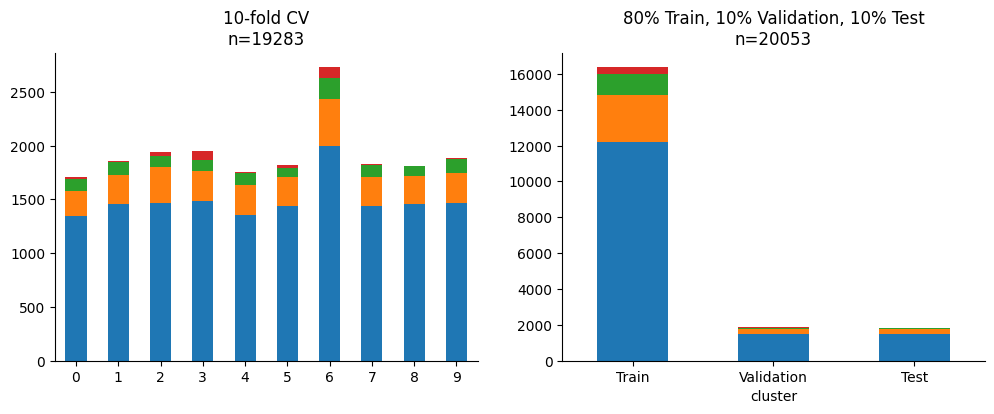

In [6]:
## show gain of retention by using trainvaltest on signalp
fig, axes = plt.subplots(1,2, figsize=(12,4))
df = pd.read_csv(f'results_splitmode/signalp_10fold.csv')
df = df.groupby(['label-val', 'cluster']).count().reset_index()
df = df.pivot(index='label-val', columns='cluster', values='AC')
df = df.fillna(0)
df = df.astype(int)
df = df.rename(columns={0:'0', 1:'1', 2:'2', 3:'3', 4:'4', 5:'5', 6:'6', 7:'7', 8:'8', 9:'9'})

# stacked barplot for each partition, no legend
# labels sorted by count
df = df.reindex(df.sum(axis=1).sort_values(ascending=False).index)
df.T.plot.bar(stacked=True, ax=axes[0], rot=0)
axes[0].set_title(f'10-fold CV\nn={df.sum().sum()}')
axes[0].get_legend().remove()
# axes[0].set_ylabel(title)
axes[0].set_xlabel('')

df = pd.read_csv(f'results_splitmode/signalp_t01va01_nm.csv')
df = df.groupby(['label-val', 'cluster']).count().reset_index()
df = df.pivot(index='label-val', columns='cluster', values='AC')
df = df.fillna(0)
df = df.astype(int)
df = df.rename(columns={0:'Train', 1:'Validation', 2:'Test', 3:'3', 4:'4'})

# stacked barplot for each partition, no legend
# labels sorted by count
df = df.reindex(df.sum(axis=1).sort_values(ascending=False).index)
df.T.plot.bar(stacked=True, ax=axes[1], rot=0)
axes[1].set_title(f'80% Train, 10% Validation, 10% Test\nn={df.sum().sum()}')
axes[1].get_legend().remove()
axes[1].set_ylabel('')
axes[0].set_xlabel('')

sns.despine()

In [22]:
df = pd.read_csv(f'results_splitmode/signalp_t01va01.csv')
df = df.groupby(['label-val', 'cluster']).count().reset_index()
df = df.pivot(index='label-val', columns='cluster', values='AC')
df = df.fillna(0)
df = df.astype(int)
df = df.rename(columns={0:'Train', 1:'Validation', 2:'Test', 3:'3', 4:'4'})
df.sum().sum()

20374

In [19]:
df.sum().sum()

cluster,Train,Validation,Test
label-val,,,
0,12209,1471,1495
1,2625,275,261
3,1178,92,60
2,351,29,7


In [27]:
df = get_data_as_df('netgpi')


ax1 = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
total = df.loc[df['algorithm'] == 'CD-HIT Partitioning'].shape[0]
add_counts_to_seaborn_plot(ax1, df, total=total)
plt.axvline(0.3, linestyle='--', color='red')
plt.title(f'NetGPI (truncated proteins) (n={total})')
plt.xlabel('Max. cross-partition identity')

14004

In [8]:
dfs = []
df = pd.read_csv('results/netgpi_partition_graphpart_mmseqs2_qc.csv')
df = pd.melt(df, value_vars=['max_ident_other'])
df['algorithm'] = "only MMseqs2"
dfs.append(df)
df = pd.read_csv('results_mmseqs2needle/netgpi_t_02_qc.csv')
df = pd.melt(df, value_vars=['max_ident_other'])
df['algorithm'] = "mmseqs2needle\n$t' = 0.20$"
dfs.append(df)
df = pd.read_csv('results_mmseqs2needle/netgpi_t_01_qc.csv')
df = pd.melt(df, value_vars=['max_ident_other'])
df['algorithm'] = "mmseqs2needle\n$t' = 0.10$"
dfs.append(df)
df = pd.read_csv('results_mmseqs2needle/netgpi_t_005_qc.csv')
df = pd.melt(df, value_vars=['max_ident_other'])
df['algorithm'] = "mmseqs2needle\n$t' = 0.05$"
dfs.append(df)

df = pd.read_csv('results/netgpi_partition_graphpart_needle_qc.csv')
df = pd.melt(df, value_vars=['max_ident_other'])
df['algorithm'] = "only Needle"
dfs.append(df)

df = pd.concat(dfs)

Text(0, 0.5, '')

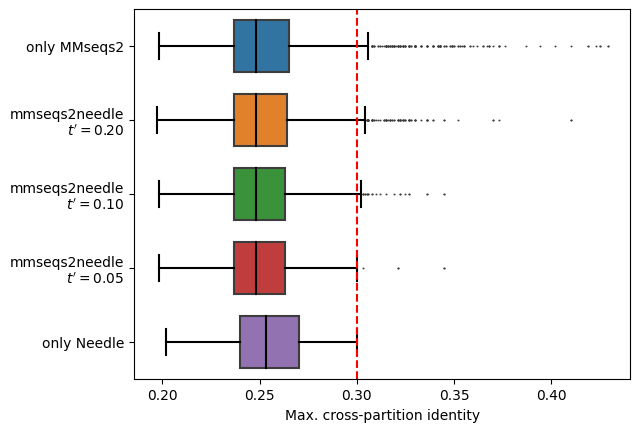

In [11]:
ax1 = sns.boxplot(data=df, y='algorithm', x='value', **PROPS)
plt.axvline(0.3, linestyle='--', color='red')
plt.xlabel('Max. cross-partition identity')
plt.ylabel('')

## Intra-partition similarities

In [6]:
df = pd.read_csv('results_intra/netgpi_partition_cd_hit.csv')

In [12]:
# load all methods and concat so that we can use seaborn boxplot
dfs = []
df = pd.read_csv('results_intra/netgpi_partition_cd_hit.csv')
df['algorithm'] = 'CD-HIT partitioning'
dfs.append(df)
df = pd.read_csv('results_intra/netgpi_reduction_cd_hit.csv')
df['algorithm'] = 'CD-HIT reduction'
dfs.append(df)
df = pd.read_csv('results_intra/netgpi_partition_mmseqs2_cmode0.csv')
df['algorithm'] = 'MMseqs2 partitioning'
dfs.append(df)
df = pd.read_csv('results_intra/netgpi_reduction_mmseqs2_cmode0.csv')
df['algorithm'] = 'MMseqs2 reduction'
dfs.append(df)
df = pd.read_csv('results_intra/netgpi_partition_graphpart_mmseqs2.csv')
df['algorithm'] = 'Graph-Part MMseqs2'
dfs.append(df)
df = pd.read_csv('results_intra/netgpi_partition_graphpart_needle.csv')
df['algorithm'] = 'Graph-Part Needle'
dfs.append(df)

df = pd.concat(dfs)

Text(0.5, 1.0, 'NetGPI')

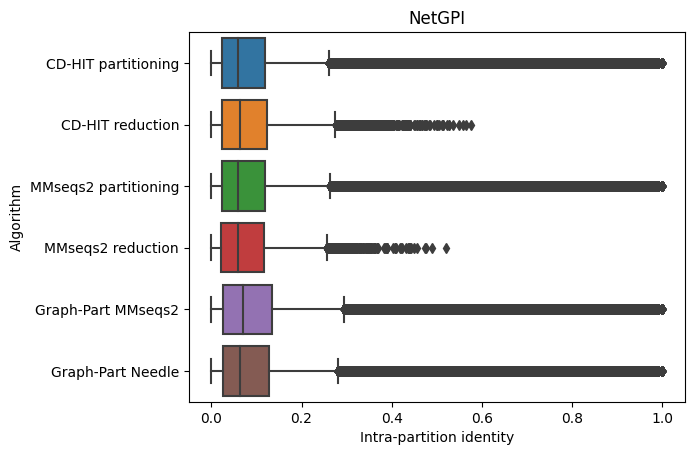

In [14]:
sns.boxplot(data=df, y='algorithm', x='0')
plt.xlabel('Intra-partition identity')
plt.ylabel('Algorithm')
plt.title('NetGPI')